# Data Exploration - IOB, COB and BG
The notebook 0.01-rd-initial-data-exploration-cob.ipynd was an early attempt to understand COB data, the quality and integrity of it. This notebook will now look at the overall sample of those that we can confidently and easily offset the timestamps (i.e. those that only have only timezone associated), and then drill down to the selected candidates that will be used for the study, based on the criteria set out in 2.01-rd-candidate-selection-analysis.ipynb.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import time
from typing import List, Tuple
from matplotlib import pyplot as plt
from IPython.display import display
from loguru import logger
from collections import defaultdict
import sys

from src.config import INTERIM_DATA_DIR
from src.sample_filter import SampleFilter
from src.configurations import FifteenMinute, ThirtyMinute

2025-07-27 14:35:29.395 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


## Raw Data Analysis
The raw data is stored in the interim directory, and we will load it to understand the structure and content of the data. This will help us to identify any issues with the data, such as missing values or inconsistencies, and to determine the best approach for cleaning and preprocessing the data.

In [2]:
irregular_df = pd.read_csv(INTERIM_DATA_DIR / 'irregular_iob_cob_bg.csv')
irregular_df['datetime'] = pd.to_datetime(irregular_df['datetime'], format='ISO8601')
irregular_df['date'] = irregular_df['datetime'].dt.date
print(f'Patient count: {irregular_df["id"].nunique()}')
print(f'Number of rows: {irregular_df.shape[0]}')
print(f'Number of unique patient dates: {irregular_df[["id", "date"]].drop_duplicates().shape[0]}')

Patient count: 114
Number of rows: 1056315
Number of unique patient dates: 10193


In [3]:
irreg_stats = irregular_df[['bg', 'iob', 'cob']].describe().T
display(irreg_stats)
irreg_table = irreg_stats.to_latex(
    index=True,
    float_format='%.2f',
    caption='Descriptive statistics of the irregularly sampled data for BG, IOB, and COB.',
    label='tab:irregular_stats',
    header=['Count', 'Mean', 'Std Dev', 'Min', '25%', '50%', '75%', 'Max'],
)
print(irreg_table)

,count,mean,std,min,25%,50%,75%,max
bg,1028030.0,138.284830,50.466897,29.00,102.00,127.000,164.000,489.000
iob,1002671.0,1.611944,2.329427,-8.06,0.14,0.898,2.335,47.567
cob,965094.0,8.554868,18.420240,0.00,0.00,0.000,8.000,223.000


\begin{table}
\caption{Descriptive statistics of the irregularly sampled data for BG, IOB, and COB.}
\label{tab:irregular_stats}
\begin{tabular}{lrrrrrrrr}
\toprule
 & Count & Mean & Std Dev & Min & 25% & 50% & 75% & Max \\
\midrule
bg & 1028030.00 & 138.28 & 50.47 & 29.00 & 102.00 & 127.00 & 164.00 & 489.00 \\
iob & 1002671.00 & 1.61 & 2.33 & -8.06 & 0.14 & 0.90 & 2.33 & 47.57 \\
cob & 965094.00 & 8.55 & 18.42 & 0.00 & 0.00 & 0.00 & 8.00 & 223.00 \\
\bottomrule
\end{tabular}
\end{table}



In [4]:
print(f'Min date: {irregular_df["date"].min()}, Max date: {irregular_df["date"].max()}')

Min date: 2000-01-01, Max date: 2021-04-06


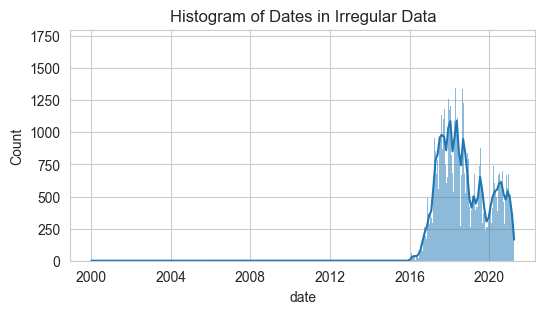

In [5]:
fig = plt.figure(figsize=(6, 3))
sns.histplot(irregular_df['date'], kde=True)
plt.title('Histogram of Dates in Irregular Data')
plt.show()

In [6]:
odd_dates = irregular_df[irregular_df['datetime'].dt.year < 2016]
print('Records with erroneous dates:')
odd_dates.groupby(['id', 'date']).size().sort_values(ascending=False)

Records with erroneous dates:


id        date      
71397255  2000-01-01    2
97417885  2000-01-01    2
dtype: int64

In [7]:
print(f'Earliest date following outlier removal: {irregular_df.drop(index=odd_dates.index)["datetime"].dt.date.min().strftime("%Y-%m-%d")}')

Earliest date following outlier removal: 2016-02-06



## Missingness from resampled data
NOTE: POSSIBLY DELETE. NOT CURRENTLY RUNNING AS NOT WORKING
Resampling data from irregular to regular intervals does not initially carry out imputation of missing values, so we will need to check the number of NaNs in the resampled data. This is important because we want to ensure that the data is complete and that there are no missing values that could affect the analysis. This will guide us on the methods used for analysis, the risks involved in introducing bias, and ultimately the methods used for imputation of missing values if this is strategy we choose to take. The following will analyse the level of missingness in the different resampled levels. in the data. The factors that will vary in the analysis are:
- The resampling interval (15 minutes, 30 minutes)
- The number of consecutive missing intervals (dependent on the resampling interval, e.g. 2 for 30 minutes, 4 for 15 minutes)
- The minimum number of nights (20, 3)
- The start and end times of the night period (e.g. 17:00 to 11:00, 22:00 to 06:00)
- The number of missing intervals (dependent on the resampling interval, e.g. 2 for 30 minutes, 4 for 15 minutes)

In [8]:
def plot_counts(counts: List[Tuple[int, int, int, int]], title, output_file):
    # counts: list of (max_length, missed_intervals, c, n)
    data = defaultdict(lambda: {'intervals': [], 'c': [], 'n': []})
    max_interval = max([i for _, i, _, _ in counts])
    max_candidates = max([c for _, _, c, _ in counts])
    max_nights = max([n for _, _, _, n in counts])
    for max_length, missed_intervals, c, n in counts:
        data[max_length]['intervals'].append(missed_intervals)
        data[max_length]['c'].append(c)
        data[max_length]['n'].append(n)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    color_map = plt.get_cmap('tab10')
    colors = [color_map(i) for i in range(len(data))]

    ax2 = ax1.twinx()

    for idx, (max_length, vals) in enumerate(sorted(data.items())):
        color = colors[idx]
        ax1.plot(vals['intervals'], vals['c'], marker='o', linestyle='-', color=color, label=f'Candidates (max_length={max_length})')
        ax2.plot(vals['intervals'], vals['n'], marker='x', linestyle='--', color=color, label=f'Nights (max_length={max_length})')

    ax1.set_xlabel('Number of Missing Intervals Allowed')
    ax1.set_xticks(np.arange(0, max_interval+1, 1))
    ax1.set_ylabel('Count of Candidates')
    ax1.set_yticks(np.arange(0, max_candidates+1, 2))
    ax2.set_ylabel('Count of Nights')
    ax2.set_yticks(np.arange(0, max_nights+1, 100))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    fig.suptitle(title)
    fig.tight_layout()

    plt.grid()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,):
    counts = []
    for missed_intervals in interval_range:
        for max_length in break_range:
            sample = SampleFilter(
                    night_start=night_start,
                    morning_end=morning_end,
                    sampling=sampling,
                    missed_intervals=missed_intervals,
                    max_break_run=max_length,
                    min_nights=min_nights,
                )
            c, n = sample.return_counts(logging=False)
            counts.append((max_length, missed_intervals, c, n))
    return counts

In [10]:
# NOTE: At 15 min sampling this takes 14mins
logger.remove()
interval_range = range(0,10)
break_range = [1,2,3]
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = FifteenMinute()
min_nights = 30
missed_intervals = 12

min_counts_a = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)

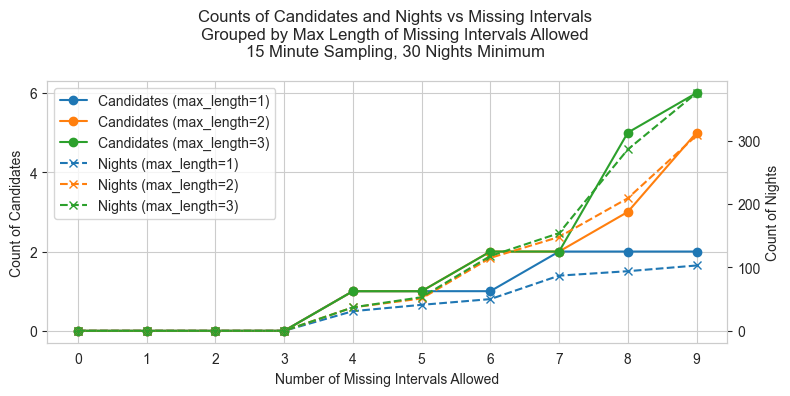

Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, in a range of up to 12 missed intervals allowed and 1-3 max consecutive intervals missed.


In [11]:
title = 'Counts of Candidates and Nights vs Missing Intervals\nGrouped by Max Length of Missing Intervals Allowed\n15 Minute Sampling, 30 Nights Minimum'
plot_counts(min_counts_a, title, output_file='../reports/figures/counts_15min_30nights.png')
print('Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, in a range of up to 12 missed intervals allowed and 1-3 max consecutive intervals missed.')

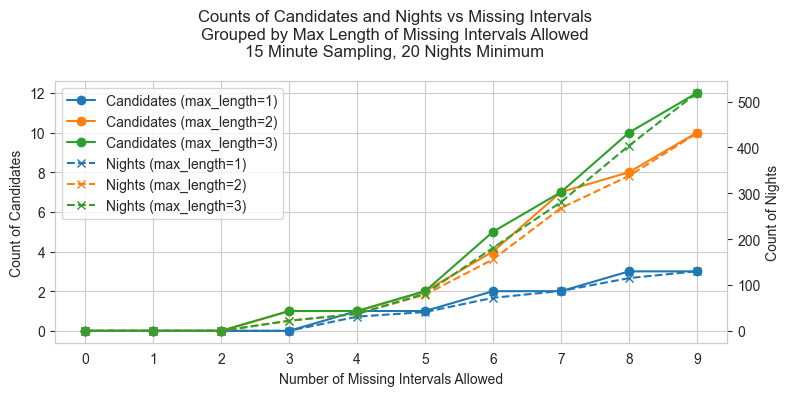

Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, and 12 missed intervals allowed.


In [12]:
# NOTE: At 15 min sampling this takes 12mins
interval_range = range(0,10)
break_range = [1,2,3]
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = FifteenMinute()
min_nights = 20

min_counts_b = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)
title = 'Counts of Candidates and Nights vs Missing Intervals\nGrouped by Max Length of Missing Intervals Allowed\n15 Minute Sampling, 20 Nights Minimum'
plot_counts(min_counts_b, title, output_file='counts_15min_20nights.png')
print('Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, and 12 missed intervals allowed.')

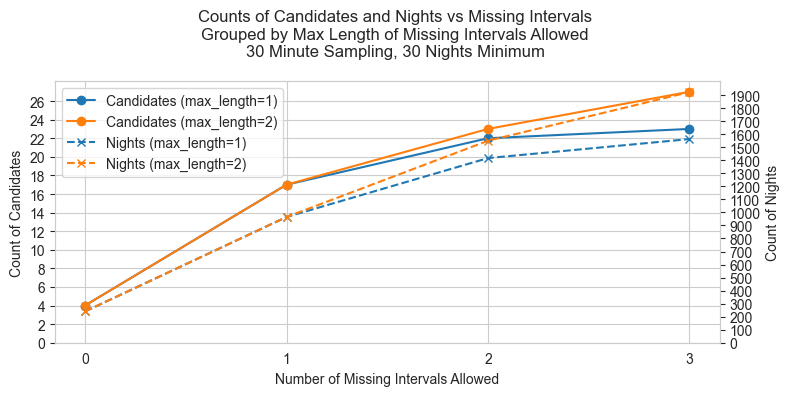

In [13]:
sampling = ThirtyMinute()
interval_range = range(0,4)
break_range = [1,2]
min_nights = 30
min_counts_b = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)
title = 'Counts of Candidates and Nights vs Missing Intervals\nGrouped by Max Length of Missing Intervals Allowed\n30 Minute Sampling, 30 Nights Minimum'
plot_counts(min_counts_b, title, output_file='../reports/figures/counts_30min_30nights.png')

It is now also clear that there are individuals with a significant amount of missing data for COB, but not totally missing COB data. This is likely due to the way that COB data is collected and processed, and it is important to note that this may affect the analysis. It will not be possible to cluster these individuals and needs to be another step in the process of selecting candidates. Lets look at the data, and find a criteria to use for selection. First, we can load the data without constraint for the period concerned.

In [14]:
logger.add(sys.stderr, level="INFO")
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 0
missed_intervals = 999
max_break_run = 999
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
)
print(f"Number of single-timezone patients: {len(sample.stats.index.unique())}")
sample.return_counts()

2025-07-27 15:07:41.021 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-07-27 15:07:50.126 | INFO     | src.sample_filter:__init__:68 - Number of nights objects created: 83
2025-07-27 15:08:03.349 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-07-27 15:08:13.109 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=0
  missed_intervals=999
2025-07-27 15:08:13.118 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 83
2025-07-27 15:08:13.120 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 6727


Number of single-timezone patients: 82


(83, 6727)

The number of candidates following filtering to a single timezone and then processing statistics for their night reduces patients to n=82. Then we need to look at understanding the proportion of missing data in the sample for individuals and look at acceptable conditions for selection. We need to minimise the number of missing values as it will impact the clustering and ability to find unbiased patterns.

In [15]:
stats = sample.stats.copy()
cob_stats = stats[stats['cob_nan_ratio']>0.0].sort_values(by='cob_nan_ratio', ascending=False)
iob_stats = stats[stats['iob_nan_ratio']>0.00].sort_values(by='iob_nan_ratio', ascending=False)
bg_stats = stats[stats['bg_nan_ratio']>0.00].sort_values(by='bg_nan_ratio', ascending=False)
print(f'Number of patients with COB missing: {len(cob_stats.index.unique())}')
display(cob_stats[['count_of_nights', 'cob_nan_ratio']].head())
print(f'Number of patients with IOB missing: {len(iob_stats.index.unique())}')
display(iob_stats[['count_of_nights', 'iob_nan_ratio']].head())
print(f'Number of patients with BG missing: {len(bg_stats.index.unique())}')
display(bg_stats[['count_of_nights', 'bg_nan_ratio']].head())

Number of patients with COB missing: 41


,count_of_nights,cob_nan_ratio
id,,
57176789,322,0.509058
68267781,291,0.467640
99296581,11,0.313131
72492570,36,0.266204
71397255,25,0.220000


Number of patients with IOB missing: 4


,count_of_nights,iob_nan_ratio
id,,
68267781,291,0.318251
72492570,36,0.191358
63725802,2,0.166667
90398368,8,0.013889


Number of patients with BG missing: 0


,count_of_nights,bg_nan_ratio
id,,


Out of n=82, without constraint put on the data, 41 have missing values from COB of up to 48% per night. 4 patients have IOB missing, and two of those have less than 30 nights so would not be included. There are no patients with BG missing intervals.

Now we introduce the constraint of 30 nights minimum and a 30 minute sampling, with a minimum of 1 missing interval in the night period, and then look at the missingness of IOB and COB. This will be the final step in setting the thresholds for data selection.

In [16]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
)

print(f"Number of single-timezone patients: {len(sample.stats.index.unique())}")
sample.return_counts()

stats = sample.stats.copy()
cob_stats = stats[stats['cob_nan_ratio']>0.0].sort_values(by='cob_nan_ratio', ascending=False)
iob_stats = stats[stats['iob_nan_ratio']>0.00].sort_values(by='iob_nan_ratio', ascending=False)
bg_stats = stats[stats['bg_nan_ratio']>0.00].sort_values(by='bg_nan_ratio', ascending=False)
print(f'Number of patients with COB missing: {len(cob_stats.index.unique())}')
display(cob_stats[['count_of_nights', 'cob_nan_ratio']].head())
print(f'Number of patients with IOB missing: {len(iob_stats.index.unique())}')
display(iob_stats[['count_of_nights', 'iob_nan_ratio']].head())
print(f'Number of patients with BG missing: {len(bg_stats.index.unique())}')
display(bg_stats[['count_of_nights', 'bg_nan_ratio']].head())

2025-07-27 15:08:28.228 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-07-27 15:08:37.739 | INFO     | src.sample_filter:__init__:68 - Number of nights objects created: 83
2025-07-27 15:08:41.361 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-07-27 15:08:41.363 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 17
2025-07-27 15:08:41.365 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 965


Number of single-timezone patients: 17
Number of patients with COB missing: 10


,count_of_nights,cob_nan_ratio
id,,
57176789,40,0.886111
97417885,36,0.082562
79526193,149,0.002237
84589080,47,0.001773
86025410,63,0.000882


Number of patients with IOB missing: 0


,count_of_nights,iob_nan_ratio
id,,


Number of patients with BG missing: 0


,count_of_nights,bg_nan_ratio
id,,


The ratio of missing COB values is significant for the patient with the highest missingness (87%). Introducing a threshold of 20% missing COB values will throttle this and remove such a concerning number.

In [17]:
df = sample.get_consolidated_df()
nan_counts = df.isna().sum()
print("Total NaNs per column:")
print(nan_counts)

Total NaNs per column:
iob mean               0
cob mean            1405
bg mean                0
iob min                0
cob min             1405
bg min                 0
iob max                0
cob max             1405
bg max                 0
iob std             4367
cob std             5548
bg std              4367
iob count              0
cob count              0
bg count               0
offset                 0
day                    0
time                   0
night_start_date       0
dtype: int64


There is significant number of NaNs in the 'cob mean' column, which is likely due to the way that the COB data is collected and processed. This is a good indication that we need to check the data for missing values and handle them appropriately before proceeding with feature extraction. This has now been addressed in the SampleFilter class, which will ensure that we only include candidates with a minimum number of COB and IOB NaNs. Setting the cob_nan_ratio and iob_nan_ratio will ensure that we have a minimum number of COB and IOB values for each candidate, which will minimise the impact of missing values on the feature extraction process. The following will show the number of NaNs in the COB columns for each candidate, which will help us understand the impact of missing values on the feature extraction process.

In [18]:
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample.apply_constraints(missed_intervals=missed_intervals,
                         max_break_run=max_break_run,
                         min_nights=min_nights,
                         cob_nan_min=cob_nan_min,
                         iob_nan_min=iob_nan_min,
                         bg_nan_min=bg_nan_min)
sample.return_counts()
df = sample.get_consolidated_df()
print('Count of intervals with NaNs for IOB and COB columns')
sample.stats[['total_cob_nans', 'total_iob_nans', 'total_bg_nans']].sum()

2025-07-27 15:08:50.125 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-07-27 15:08:50.127 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 16
2025-07-27 15:08:50.128 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 922


Count of intervals with NaNs for IOB and COB columns


total_cob_nans    23
total_iob_nans     0
total_bg_nans      0
dtype: int64

In [19]:
# Count number of consecutive NaNs in 'cob mean' column
df_isna = df[df['cob mean'].isna()].copy()
df_reset = df_isna.reset_index().sort_values(['id', 'datetime'])
df_reset['time_diff'] = df_reset.groupby('id')['datetime'].diff().dt.total_seconds() / 60
diffs = df_reset.groupby('id')['time_diff'].apply(lambda x: (x == 30).sum()).reset_index()
diffs[diffs['time_diff']>0]

,id,time_diff
5,79526193,2


There is only a single instance where these NaNs span greater than 30 minutes, which is the minimum interval between two consecutive COB measurements. This is very minimal and means that we can proceed with imputation of these NaNs in preparation for feature extraction.